In [134]:
#Gives sum of next 30 days output expected
#Try add two years ago as well and see what happens. 
#Add more statistics
#Try polynomial predictor and try LSTM see what happens. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor


In [135]:
electricity_ng = pd.read_csv('Dataset/PV_Elec_Gas2.csv').rename(columns={'Unnamed: 0': 'Date'})
solar_output = pd.read_csv('Dataset/solarpower_cumuldaybyday2.csv').drop(columns='Unnamed: 2')


In [136]:
def get_month(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    month = date.month
    return month
def get_yr(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    year = date.year
    return year
def get_day(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    day = date.day
    return day

def days_change(x,y):
    date_1 = datetime.strptime(x, "%Y-%m-%d")
    date_2 = datetime.strptime(y, "%Y-%m-%d")
    chng = (date_2 - date_1).days
    return chng

electricity_ng['month'] = electricity_ng['Date'].apply(get_month)
electricity_ng['year'] = electricity_ng['Date'].apply(get_yr)
electricity_ng['yesterday_power'] = electricity_ng['cum_power'].shift(1)
electricity_ng['yesterday'] = electricity_ng['Date'].shift(1)
electricity_ng = electricity_ng.dropna()
electricity_ng
electricity_ng['days'] = electricity_ng.apply(lambda x: days_change(x['yesterday'], x['Date']),axis=1)
electricity_ng['output/day'] = (electricity_ng['cum_power'] - electricity_ng['yesterday_power'])/electricity_ng['days']
electricity_ng['day_of_month'] = electricity_ng['Date'].apply(get_day)



analyze = electricity_ng[['Date','year', 'month', 'day_of_month', 'output/day']]
analyze['target'] = analyze['output/day'].shift(-1)
analyze['target'] = analyze['target'].shift(-30).rolling(window=30).sum()


#analyze.to_csv('check.csv')



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [137]:
def mv_avg(df):
    mvg_avg_lst = [2,3,4,5,7,10,15,20,25,30,45]
    for i in mvg_avg_lst:
        column_name = 'mv_avg_' + str(i)
        df[column_name] = df.iloc[:,4].rolling(window=i).mean()
    return df
# df = mv_avg(analyze)
# df[df['year']==2013]


In [138]:
#Get moving average this time last year and 1 year before for each date
def year_over_yr(data):
    yr = 2011
    yrs = {}
    target = data[['year', 'month', 'day_of_month', 'target']].copy()
    data = data.drop(columns ='target')
    for i in range(0, (max(data['year']) - yr) + 1):
        frame_name = 'year' + str(yr) + 'data' 
        yrs[frame_name] = data[data['year']==yr]
        yr +=1

    
    #Get_last year
    data_set = {}
    for item in [2013,2014,2015,2016,2017,2018,2019]:
        last_yr = item-1
        lst_yr = 'year' + str(last_yr) + 'data' 
        this_yr = 'year' + str(item) + 'data' 
        
        data_last_year = yrs[lst_yr]
        
        
        for column in data_last_year.columns:
            if 'mv_avg' in column:
                data_last_year = data_last_year.rename(columns={column: 'lst_yr_' + str(column)})

        data_this_year = yrs[this_yr]
        iter_frame = pd.DataFrame()
        data_last_year = data_last_year.drop(columns=['Date', 'year', 'output/day'])
        data_this_year =  data_this_year.drop(columns=['Date', 'year'])
        iter_frame = pd.merge(data_this_year,data_last_year, on =['month', 'day_of_month'], how='left')
        iter_frame.insert(0, 'year', item)
        
        data_set[item] = iter_frame

    final_frame = pd.DataFrame()
    i = 0
    for item in data_set.keys():
        if i == 0:
            final_frame = data_set[item]    
            i+=1
            continue
        final_frame = final_frame.append(data_set[item])
  
    final_frame = pd.merge(final_frame,target, on =['year', 'month', 'day_of_month'],how='left')
    final_frame = final_frame.sort_values(by=['year', 'month', 'day_of_month'], ascending=True)
    return final_frame


# df1 = year_over_yr(df)
# df1[(df1['month']==1) & (df1['year']==2013)]


In [139]:
def past_performance(DF):
    past_performance = DF[['year', 'month', 'day_of_month', 'target']]
    past_performance['year+1'] = past_performance['year'] + 1
    past_performance = past_performance[past_performance['year']!=2011]
    past_stats = {}
    for year in list(set(past_performance['year'])):
        if year not in [2011,2012]:
            Frame_name = str(year) + '_pd'
            iter_frame = past_performance[past_performance['year']<year]
            


            past_stats_df = iter_frame[~(iter_frame['target'].isna())].groupby(['month', 'day_of_month'])['target'].agg(['mean', 'std', 'min', 'max']).reset_index()
            last_year = year -1
            last_year_data = iter_frame[iter_frame['year']==last_year]
            last_year_data = last_year_data[['month', 'day_of_month', 'target']]
            last_year_data = last_year_data.rename(columns={'target': 'last_year'})
            put_together = pd.merge(past_stats_df, last_year_data, on =['month', 'day_of_month'],how='left')
            put_together.insert(0, 'year', year)
            #put_together['std'] = put_together['std'].fillna
            past_stats[Frame_name] = put_together
            
    return_this = pd.DataFrame()
    for key in past_stats:
        return_this = return_this.append(past_stats[key])
    return return_this











In [143]:
def day_dums(data):

    data = data[data['year']> 2012]
    day = [0,5,10, 15,20,25]
    day_buckets = pd.DataFrame()
    for j in range(0,len(day)):
        start = day[j]
        if j != len(day)-1:
            end = day[j+1]
        else:
            continue
        c_n = 'day>=_' + str(start)+ '_day_<' + str(end)
        day_buckets[c_n] = data.apply(lambda x: 1 if x['day_of_month'] >= start and x['day_of_month'] < end else 0,axis=1)
    day_buckets
    pd.set_option('display.max_rows',300)
    dummies = day_buckets
    merger_data = data[['year', 'month', 'day_of_month']]
    month_dummies = pd.get_dummies(data[data['year']>2012]['month'])
    Trans_frm = merger_data.join(month_dummies)
    Trans_frm = Trans_frm.join(dummies)
    
    return Trans_frm




In [144]:
def pipeline(dataframe):
    dummies = day_dums(dataframe)
    T_1 = mv_avg(dataframe)
    T_2 = year_over_yr(T_1)
    T = pd.merge(dummies, T_2, on=['year', 'month', 'day_of_month'],how='outer')
    past_data = past_performance(DF=analyze)
    T = pd.merge(T, past_data, on =['year','month', 'day_of_month'])
    return T
pd.set_option("display.max_rows",300)


data = pipeline(analyze)
data = data[~(data['std'].isna())]
data.to_csv('validate.csv')


train = data[data['year'] < 2019]
train.to_csv('model_data/train.csv')
train = train[(train['month']!=2) | (train['day_of_month']!= 29)]
test = data[data['year']==2019]
test.to_csv('model_data/test.csv')
train[pd.isnull(train).any(axis=1)]
y = train.pop('target')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [145]:
from sklearn.linear_model import LinearRegression
y3 = train[train['year']==2018]['mean']
train = train.drop(columns=['year', 'month', 'day_of_month'])
x = train.values
mod = RandomForestRegressor().fit(x,y)#LinearRegression(normalize=True).fit(x, y)
mod.score(x, y)


#With linear coeff of determinaton = 0.95

0.9988387482771957

In [146]:
# test
actual = test.pop('target')
meta = test[['year', 'month', 'day_of_month']]
test = test.drop(columns=['year', 'month', 'day_of_month'])

pred = mod.predict(test.values)

In [147]:
anal_ize = pd.DataFrame()
anal_ize['actual'] = actual
anal_ize['predicted'] = pred
anal_ize['error'] = abs(anal_ize['actual'] -anal_ize['predicted'])
anal_ize = meta.join(anal_ize)
anal_ize['error'].sum()
anal_ize = anal_ize.dropna()
anal_ize = anal_ize.reset_index(drop=True)
anal_ize['%err'] = anal_ize['error']/anal_ize['actual']

test = test.reset_index(drop=True)
result = anal_ize.join(test, how='inner')

result.sort_values(by='%err', ascending=False)


,year,month,day_of_month,actual,predicted,error,%err,1,2,3,4,5,6,7,8,9,10,11,12,day>=_0_day_<5,day>=_5_day_<10,day>=_10_day_<15,day>=_15_day_<20,day>=_20_day_<25,output/day,mv_avg_2,mv_avg_3,mv_avg_4,mv_avg_5,mv_avg_7,mv_avg_10,mv_avg_15,mv_avg_20,mv_avg_25,mv_avg_30,mv_avg_45,lst_yr_mv_avg_2,lst_yr_mv_avg_3,lst_yr_mv_avg_4,lst_yr_mv_avg_5,lst_yr_mv_avg_7,lst_yr_mv_avg_10,lst_yr_mv_avg_15,lst_yr_mv_avg_20,lst_yr_mv_avg_25,lst_yr_mv_avg_30,lst_yr_mv_avg_45,mean,std,min,max,last_year
264,2019,9,22,169.0,287.85,118.85,0.703254,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,17.0,16.5,15.000000,13.50,13.6,14.428571,13.9,13.600000,13.15,14.12,15.166667,15.288889,17.0,15.666667,16.25,16.6,15.285714,13.5,14.533333,14.15,14.36,14.000000,14.622222,253.371429,30.149058,224.0,316.0,316.0
265,2019,9,23,163.0,273.41,110.41,0.677362,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,9.0,13.0,14.000000,13.50,12.6,14.571429,13.3,13.533333,12.75,13.84,14.733333,15.022222,11.0,13.000000,13.00,14.0,14.571429,13.0,13.466667,13.35,13.92,13.800000,14.333333,250.485714,32.074675,219.0,318.0,318.0
263,2019,9,21,170.0,284.18,114.18,0.671647,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,16.0,14.0,12.333333,12.75,15.2,13.571429,12.6,13.600000,13.15,14.20,15.400000,15.377778,15.0,16.000000,16.50,16.0,14.142857,13.9,14.333333,14.55,14.04,14.200000,14.644444,256.371429,27.122544,231.0,313.0,313.0
272,2019,9,30,163.0,257.03,94.03,0.576871,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6.0,7.0,8.000000,6.75,6.4,6.857143,9.0,10.533333,10.75,11.44,11.733333,13.977778,13.5,14.333333,15.00,14.8,13.285714,13.2,13.666667,13.25,13.72,13.866667,14.222222,200.071429,20.543508,185.0,245.0,245.0
270,2019,9,28,165.0,257.65,92.65,0.561515,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,10.0,6.5,6.000000,5.25,6.8,8.571429,9.7,11.133333,11.85,11.56,12.666667,14.222222,16.5,15.666667,15.50,13.2,12.571429,13.6,13.066667,13.40,13.32,13.800000,14.066667,213.300000,25.856592,194.0,266.0,266.0
262,2019,9,20,185.0,286.93,101.93,0.550973,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,12.0,10.5,11.666667,15.00,13.6,13.000000,12.5,13.066667,13.10,14.32,15.600000,15.400000,15.5,16.333333,15.75,14.6,13.000000,13.3,14.066667,14.20,13.68,14.166667,14.822222,264.042857,28.407385,242.0,324.0,324.0
266,2019,9,24,168.0,259.24,91.24,0.543095,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,13.0,11.0,13.000000,13.75,13.4,12.857143,13.4,13.066667,13.00,13.56,14.433333,15.066667,4.5,8.666667,10.75,11.2,13.142857,12.5,13.066667,13.30,13.88,13.466667,14.266667,242.542857,31.198229,214.0,305.0,305.0
271,2019,9,29,165.0,254.19,89.19,0.540545,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,8.0,9.0,7.000000,6.50,5.8,7.285714,9.6,10.866667,11.25,11.56,12.266667,14.133333,14.0,15.000000,14.75,14.8,11.857143,13.0,13.266667,13.50,13.60,14.033333,14.111111,206.885714,21.603042,191.0,253.0,253.0
269,2019,9,27,169.0,257.83,88.83,0.525621,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.0,4.0,3.666667,6.00,6.6,9.428571,10.1,11.466667,11.85,11.84,12.866667,14.311111,15.5,15.333333,12.50,11.0,12.714286,13.8,12.666667,13.65,13.52,13.800000,14.022222,219.857143,24.882581,199.0,271.0,271.0
267,2019,9,25,168.0,255.16,87.16,0.518810,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.0,8.0,8.333333,10.50,11.6,11.285714,12.6,12.200000,12.70,12.80,13.866667,14.666667,9.5,8.000000,10.25,11.6,12.714286,13.1,12.733333,13.45,13.68,13.333333,14.222222,234.871429,30.023586,206.0,294.0,294.0


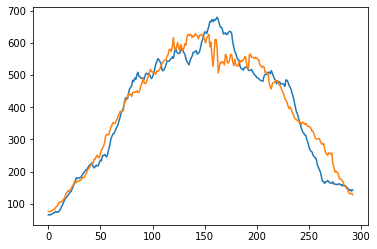

In [148]:
# x = anal_ize['actual']
x = anal_ize.index
y1 = anal_ize['actual']
y2 = anal_ize['predicted']




plt.plot(x,y1)
plt.plot(x,y2)




In [149]:
anal_ize['%err'] = anal_ize['error']/anal_ize['actual']
anal_ize['%err'].mean()
#anal_ize[anal_ize['month']==6]

0.11365197190499426